# **Add libraries and functions**

In [1]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from skimage.filters import rank
from sklearn.utils import shuffle
import skimage.morphology as morp

import torch
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from torch.utils.data import TensorDataset, DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms, datasets, models
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score
from torch.autograd import Variable

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

def calc_gradient_penalty(x, y_pred_sum):
    gradients = torch.autograd.grad(
        outputs=y_pred_sum,
        inputs=x,
        grad_outputs=torch.ones_like(y_pred_sum),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradients = gradients.flatten(start_dim=1)

    # L2 norm
    grad_norm = gradients.norm(2, dim=1)

    # Two sided penalty
    gradient_penalty = ((grad_norm - 1) ** 2).mean()

    return gradient_penalty

# **Load the official GTSRB Dataset**

In [ ]:
import os
import csv
from PIL import Image
import shutil
from collections import defaultdict, namedtuple

Annotation = namedtuple('Annotation', ['filename', 'label'])
def read_annotations(filename):
    annotations = []
    with open(filename) as f:
        reader = csv.reader(f, delimiter=';')
        next(reader) # skip header

        # loop over all images in current annotations file
        for row in reader:
            filename = row[0] # filename is in the 0th column
            label = int(row[7]) # label is in the 7th column
            annotations.append(Annotation(filename, label))
    return annotations

def load_training_annotations(source_path):
    annotations = []
    for c in range(0,43):
        filename = os.path.join(source_path, format(c, '05d'), 'GT-' + format(c, '05d') + '.csv')
        annotations.extend(read_annotations(filename))
    return annotations

def copy_files(label, filenames, source, destination, move=False):
    func = os.rename if move else shutil.copyfile

    label_path = os.path.join(destination, str(label))
    if not os.path.exists(label_path):
        os.makedirs(label_path)

    for filename in filenames:
        destination_path = os.path.join(label_path, filename)
        if not os.path.exists(destination_path):
            func(os.path.join(source, format(label, '05d'), filename), destination_path)

def maketrain(source_path, train_path):
    if not os.path.exists(train_path):
        os.makedirs(train_path)

    annotations = load_training_annotations(source_path)
    filenames = defaultdict(list)
    for annotation in annotations:
        filenames[annotation.label].append(annotation.filename)

    for label, filenames in filenames.items():
        filenames = sorted(filenames)
        train_filenames = filenames
        copy_files(label, train_filenames, source_path, train_path, move=True)

def maketest(source="temp/test/Images", dest = "original/test", ann = 'temp/GT-final_test.csv'):
    path = os.getcwd()

    if os.path.exists(os.path.join(path,dest)):
      shutil.rmtree(os.path.join(path,dest))
    os.mkdir(os.path.join(path,dest))

    test_annotations = read_annotations(ann)
    testpath = os.path.join(path,dest)
    source = os.path.join(path,source)
    num = 0
    for i in test_annotations:
        label = i.label;
        folder = os.path.join(testpath,"{}".format(label))
        if not os.path.exists(folder):
            os.mkdir(folder)
        newfile = '{}'.format(num)
        shutil.move(os.path.join(source,i.filename),os.path.join(folder,newfile+'.ppm'))
        im = Image.open(dest +"/{}/".format(label) +newfile + '.ppm')
        im.save(dest+"/{}/".format(label)+newfile+".jpg")
        os.remove(os.path.join(folder,newfile+'.ppm'))
        num +=1
    shutil.rmtree(source)

! rm -r temp
! rm -r original
! mkdir temp
! mkdir temp/test
! mkdir temp/train
! mkdir temp/test2
! mkdir temp/GT
! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip -P temp/zip
! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip -P temp/zip
! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip -P temp/zip
! unzip temp/zip/GTSRB_Final_Training_Images -d temp/train
! unzip temp/zip/GTSRB_Final_Test_Images -d temp/test2
! unzip -o temp/zip/GTSRB_Final_Test_GT.zip -d temp/GT

! mv temp/test2/GTSRB/Final_Test/Images/ temp/test

path = os.getcwd()
source_path = os.path.join(path, 'temp/train/GTSRB/Final_Training/Images')
train_path = os.path.join(path, 'original/train')
maketrain(source_path,train_path)
maketest("temp/test/Images","original/test",'temp/GT/GT-final_test.csv')
!rm -r temp

# **Classes included**

In [3]:
signs = np.arange(0,43)
n_classes = 43

# **Pre-processing**

In [4]:
def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def local_histo_equalize(image):
    """
    Apply local histogram equalization to grayscale images.
        Parameters:
            image: A grayscale image.
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local
def scale(image):
    """
    Normalize images to [0, 1] scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    image = np.divide(image, 255)
    return image
def preprocess(X_train, y_train):
  print(X_train.shape)
  X_train, y_train = shuffle(X_train, y_train)
  gray_images = np.array(list(map(gray_scale, X_train)))
  equalized_images =  np.array(list(map(local_histo_equalize, gray_images)))
  X_train  = np.array(list(map(image_normalize, equalized_images)))
 
  return X_train, y_train


# **Hyperparameters**

In [5]:
batchsize = 64
sz = 40

# **Transforms**

In [6]:
test_transform = transforms.Compose([
    transforms.Resize((sz,sz)),
    transforms.ToTensor()
])

data_flip = transforms.Compose([
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.Normalize(0,1)
     #AddGaussianNoise(0., 10/255)
])

# Resize, normalize and jitter image brightness
data_jitter_brightness = transforms.Compose([
	  transforms.Resize((32, 32)),
    transforms.ColorJitter(brightness=5),
    transforms.Normalize(0,1)
])


# Resize, normalize and rotate image
data_rotate = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.RandomRotation(15),
    transforms.Normalize(0,1)
])


# Resize, normalize and shear image
data_shear = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.RandomAffine(degrees = 15,shear=2),
    transforms.Normalize(0,1)
])

# Resize, normalize and translate image
data_translate = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.RandomAffine(degrees = 15,translate=(0.1,0.1)),
    transforms.Normalize(0,1)
])

# Resize, normalize and crop image 
data_center = transforms.Compose([
	  transforms.Resize((36, 36)),
    transforms.CenterCrop(32),
    transforms.Normalize(0,1)
])
# Resize, normalize and jitter image saturation
data_jitter_saturation = transforms.Compose([
	  transforms.Resize((32, 32)),
    transforms.ColorJitter(saturation=5),
    transforms.Normalize(0,1)
])

# Resize, normalize and jitter image contrast
data_jitter_contrast = transforms.Compose([
	  transforms.Resize((32, 32)),
    transforms.ColorJitter(contrast=5),
    transforms.Normalize(0,1)
    ])

# Resize, normalize and jitter image hues
data_jitter_hue = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.ColorJitter(hue=0.4),
    transforms.Normalize(0,1)
])

# **Making the dataset and loaders**

In [7]:
split = 0.1
train_ds = datasets.ImageFolder('original/train',transform = test_transform)
num = int(split*len(train_ds))
train_ds, val_ds = torch.utils.data.random_split(train_ds, [len(train_ds)-num,num])
test_ds = datasets.ImageFolder('original/test',transform = test_transform)

train_loader = DataLoader(train_ds,batchsize,shuffle = True);
# Imp to keep only 1 batch for test and valid because of other experiments
test_loader = DataLoader(test_ds,len(test_ds),shuffle = True);
val_loader = DataLoader(val_ds,len(val_ds),shuffle = True);

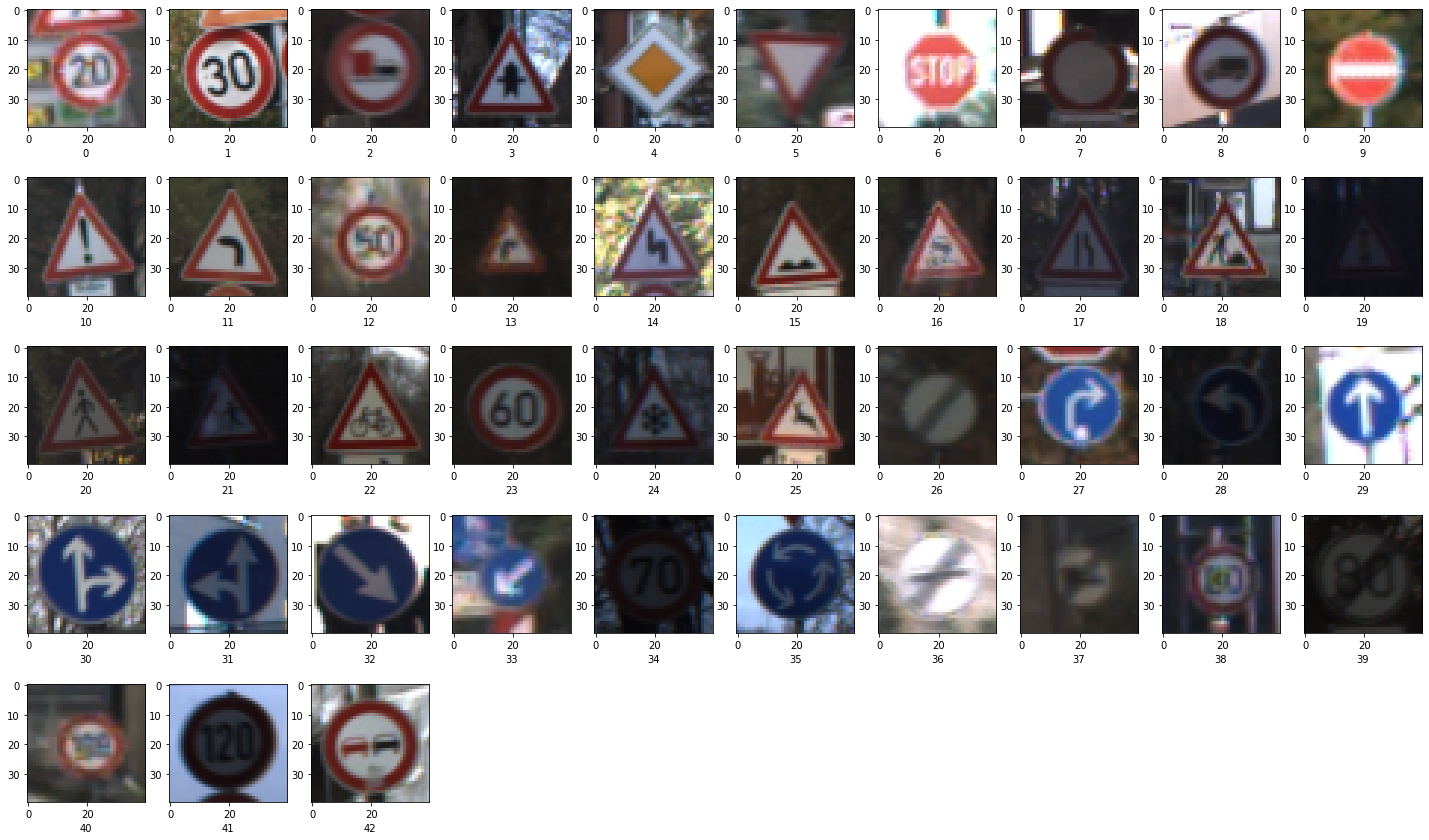

In [8]:
imgs = [None]*43
st = [False]*43
for _, (X_valid, y_valid) in enumerate(val_loader):
  break
X_valid = X_valid.numpy()
y_valid = y_valid.numpy()

for i in range(len(X_valid)):
  if(not st[y_valid[i]]):
    st[y_valid[i]] = True
    imgs[y_valid[i]]= X_valid[i]
plt.figure(figsize=(25, 15))
for i in range(43):
  plt.subplot(5,10, i+1)
  plt.imshow(np.moveaxis(imgs[i],0,-1),interpolation='nearest',)
  plt.xlabel(signs[i])
plt.show()

# **MODEL**

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.checkpoint import checkpoint

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.grad = None
        self.cam = False
        # CNN layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            # inplace=True -> сохранить немного памяти
            nn.LeakyReLU(),
            
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=14),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128,128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 128, kernel_size=5, stride=2, padding=6),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.25),
            
        )
        
        self.conv3 = nn.Sequential(
            nn.AvgPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=5, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.5)
        )
        
        self.fc = nn.Sequential(
            #nn.Linear(128 * 1 * 1, 128),
        )

        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
            )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 6 * 6, sz),
            nn.ReLU(True),
            nn.Linear(sz, 3 * 2),
            )
        
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # For Grad
    def activations_hook(self,grad):
        self.grad = grad
    def activations(self,x):
        x = self.stn(x)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 6 * 6)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def compute_features(self, x):
        x = self.stn(x)
        self.datain = x
        x = self.conv1(x)
        x = self.conv2(x)
        
        if self.cam:
          h = x.register_hook(self.activations_hook)

        x = self.conv3(x)
        #print(x.shape)
        x = x.view(-1, 256 * 3 * 3)
        x = self.fc(x)
        return x

class CNN_DUQ(Net):
    def __init__(
        self,
        input_size,
        num_classes,
        centroid_size,
        model_output_size,
        length_scale,
        gamma,
        input_dep_ls=False
    ):
        super().__init__()

        self.gamma = gamma
        self.input_dep_ls=input_dep_ls
        self.W = nn.Parameter(
            torch.zeros(centroid_size, num_classes, model_output_size))
        nn.init.kaiming_normal_(self.W, nonlinearity="relu")
        self.register_buffer("N", torch.zeros(num_classes) + 13)
        self.register_buffer(
            "m", torch.normal(torch.zeros(centroid_size, num_classes), 0.05)
        )
        self.m = self.m * self.N
        
        if input_dep_ls:
            self.sigmann = nn.Sequential(
              nn.Linear(model_output_size, 100),
              nn.ReLU(True),
              nn.Dropout2d(0.35),
              nn.Linear(100, 1))
        self.sigma = length_scale*length_scale

    def rbf(self, z):
    
        if self.input_dep_ls:
            self.sigma = torch.sigmoid(self.sigmann(z)/50)+0.001

        z = torch.einsum("ij,mnj->imn", z, self.W)

        embeddings = self.m / self.N.unsqueeze(0)

        diff = z - embeddings.unsqueeze(0)
        diff = (- diff ** 2).mean(1).div(2 * (self.sigma)).exp()

        return diff

    def update_embeddings(self, x, y):
        self.N = self.gamma * self.N + (1 - self.gamma) * y.sum(0)

        z = self.compute_features(x)

        z = torch.einsum("ij,mnj->imn", z, self.W)
        embedding_sum = torch.einsum("ijk,ik->jk", z, y)

        self.m = self.gamma * self.m + (1 - self.gamma) * embedding_sum

    def forward(self, x):
        z = self.compute_features(x)
        y_pred = self.rbf(z)
        return y_pred

length_scale = 0.6
input_size = 32
num_classes = 43
output_size = 256*3*3
embedding_size = 100
learnable_length_scale = False #Learnable length scale
gamma = 0.999
input_dep_ls = True
torch.cuda.empty_cache()
network = []
network = CNN_DUQ(input_size,num_classes,embedding_size,output_size,length_scale,gamma,input_dep_ls).float().cuda()

# **Training and testing**

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd
import numpy as np
valid_df = []
test_df = []
vlogit = []
tlogit = []

def train(model, train_loader, epochs, cudav):

  learning_rate = 0.0005
  momentum = 0.1
  weight_decay = 0.0001
  lm = 0.1
  log_interval = 20
  optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr=learning_rate,weight_decay=weight_decay)
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer,[8,10,14],0.5)

  for epoch in range(epochs):
    loss_=[]
    correct_=0

    for batch_idx, (data, target) in enumerate(train_loader):
      data, target = Variable(data), Variable(target).long()
      if cudav :
        torch.cuda.empty_cache()
        data=data.cuda(); target=target.cuda();
      model.train()

      optimizer.zero_grad()
      output = model(data)
      pred = output.data.argmax(1).long()
      datain = model.datain
      loss = 10*F.binary_cross_entropy(output, F.one_hot(target,43).float()) + lm*calc_gradient_penalty(datain,output.sum(1)) 
      correct = pred.eq(target.data.view_as(pred)).sum().item()
      loss.backward()
      optimizer.step()

      loss_.append(loss.item())
      correct_+=correct

      with torch.no_grad():
        model.eval()
        model.update_embeddings(data,F.one_hot(target.long(),43).float())

      if batch_idx % log_interval == 0:
        trainlog(batch_idx,100.*correct/len(data),loss.item())

    trainlog(epoch,100.*correct_/len(train_loader.dataset),np.array(loss_).mean())
    scheduler.step()

  if cudav:
    torch.cuda.empty_cache()



def validation(model,val_loader,cudav):
  model.eval()
  global vlogit, valid_df
  criterion = nn.CrossEntropyLoss()
  y_true = []
  y = []
  y_conf = []
  logits = []
  val_loss_ = []
  correct_ = 0

  with torch.no_grad():
    for _,(data, target) in enumerate(val_loader):
      target = target.long()
      if cudav:
        torch.cuda.empty_cache()
        data = data.cuda()
        target = target.cuda()

      output = model(data)
      pred = output.data.argmax(1).long()
      conf = output.data.max(1)[0]

      val_loss = criterion(output, target.long()).item()
      correct = pred.eq(target.long().data.view_as(pred)).sum().item()
      val_loss_.append(val_loss)
      correct_+=correct

      logits.append(output.cpu().numpy())
      y_true.append(target.cpu().numpy())
      y_conf.append(conf.cpu().numpy())
      y.append(pred.cpu().numpy())

  y_true = np.hstack(y_true)
  y_conf = np.hstack(y_conf)
  y = np.hstack(y)
  vlogit = np.hstack(logits)
  data = np.column_stack([y_true, y, y_conf])

  global valid_df
  valid_df = pd.DataFrame(data=data,columns=['label','pred','conf'])

  trainlog(1,100.*correct_/len(val_loader.dataset),np.array(val_loss_).mean())
  if cudav:
    torch.cuda.empty_cache()



def test(model,test_loader, cudav):
  model.eval()
  global tlogit, test_df
  criterion = nn.CrossEntropyLoss()
  y_true = []
  y = []
  y_conf = []
  logits = []
  test_loss_ = []
  correct_ = 0

  with torch.no_grad():
    for _,(data, target) in enumerate(test_loader):
      target = target.long()
      if cudav:
        torch.cuda.empty_cache()
        data = data.cuda()
        target = target.cuda()

      output = model(data)
      pred = output.data.argmax(1).long()
      conf = output.data.max(1)[0]

      test_loss = criterion(output, target.long()).item()
      correct = pred.eq(target.data.view_as(pred)).sum().item()
      test_loss_.append(test_loss)
      correct_+=correct

      logits.append(output.cpu().numpy())
      y_true.append(target.cpu().numpy())
      y_conf.append(conf.cpu().numpy())
      y.append(pred.cpu().numpy())

  y_true = np.hstack(y_true)
  y_conf = np.hstack(y_conf)
  y = np.hstack(y)
  tlogit = np.hstack(logits)
  data = np.column_stack([y_true, y, y_conf])

  test_df = pd.DataFrame(data=data,columns=['label','pred','conf'])
  trainlog(1,100.*correct_/len(test_loader.dataset),np.array(test_loss_).mean())
  print("f1 = ", f1_score(y_true,y,average="macro"))
  if cudav:
    torch.cuda.empty_cache()



def trainlog(epoch, correct, loss):
  print("epoch = {}, correct = {}, loss = {}".format(epoch,correct,loss));

train(network,train_loader,15,True)
validation(network,val_loader,True)
test(network,test_loader,True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


epoch = 0, correct = 3.125, loss = 32.0139274597168
epoch = 20, correct = 9.375, loss = 1.3181456327438354
epoch = 40, correct = 6.25, loss = 1.2153230905532837
epoch = 60, correct = 1.5625, loss = 1.1320075988769531
epoch = 80, correct = 7.8125, loss = 1.165101170539856
epoch = 100, correct = 3.125, loss = 1.132721185684204
epoch = 120, correct = 3.125, loss = 1.176897406578064
epoch = 140, correct = 9.375, loss = 1.1077210903167725
epoch = 160, correct = 7.8125, loss = 1.0670981407165527
epoch = 180, correct = 10.9375, loss = 1.107979416847229
epoch = 200, correct = 10.9375, loss = 1.082695484161377
epoch = 220, correct = 4.6875, loss = 1.0942792892456055
epoch = 240, correct = 12.5, loss = 1.0550196170806885
epoch = 260, correct = 10.9375, loss = 0.9652129411697388
epoch = 280, correct = 12.5, loss = 1.0065499544143677
epoch = 300, correct = 14.0625, loss = 0.9750291109085083
epoch = 320, correct = 15.625, loss = 1.0590859651565552
epoch = 340, correct = 15.625, loss = 0.95337599515

# **Visualizing STN**

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


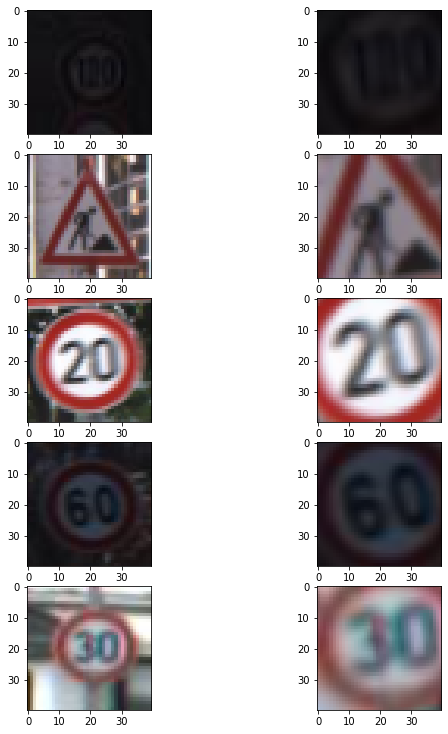

In [22]:
for i, (data,target) in enumerate(test_loader):
  break
network.eval()
a = data[:,:,:,:].detach()
b = network.stn(data[:,:,:,:].cuda()).cpu().detach()[:,:,:,:]
c = target.long()

def norm (a):
    a = (a-a.min())
    a/=(a.max())
    return a+0.00001


num=5
plt.figure(figsize=(10,2*num))
for i in range(num):
  plt.subplot(num,2,i*2+1)
  plt.imshow(a[i].permute(1,2,0))
  plt.subplot(num,2,i*2+2)
  plt.imshow(b[i].permute(1,2,0))
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()


# **Other Plots**

# Confusion Matrix

[[1.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.9972 0.     ... 0.     0.     0.    ]
 [0.     0.0015 0.997  ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.98   0.0111 0.    ]
 [0.     0.     0.     ... 0.     0.9822 0.    ]
 [0.     0.     0.     ... 0.     0.     1.    ]]


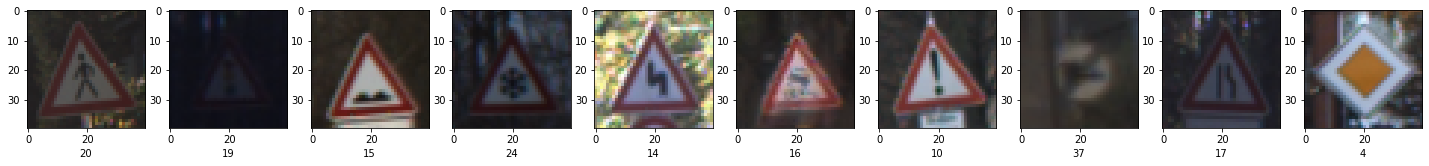

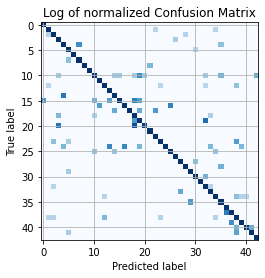

In [12]:
import sys
import numpy
numpy.set_printoptions(threshold = 5,linewidth=70)
cm = confusion_matrix(test_df['label'],test_df['pred'])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print(np.round(cm,4))

# Most misclassified
mn = []
for i in range (0,43):
  mn.append(cm[i][i])
mn = np.array(mn);
mne = np.argsort(mn)[:10]
plt.figure(figsize=(25, 5))
for i in range(len(mne)):
  plt.subplot(1,10, i+1)
  plt.imshow(np.moveaxis(imgs[mne[i]],0,-1),interpolation='nearest',)
  plt.xlabel(signs[mne[i]])
plt.show()

# matrix
cm = np.log(.0001 + cm)
plt.grid(True,'both')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# ROCs

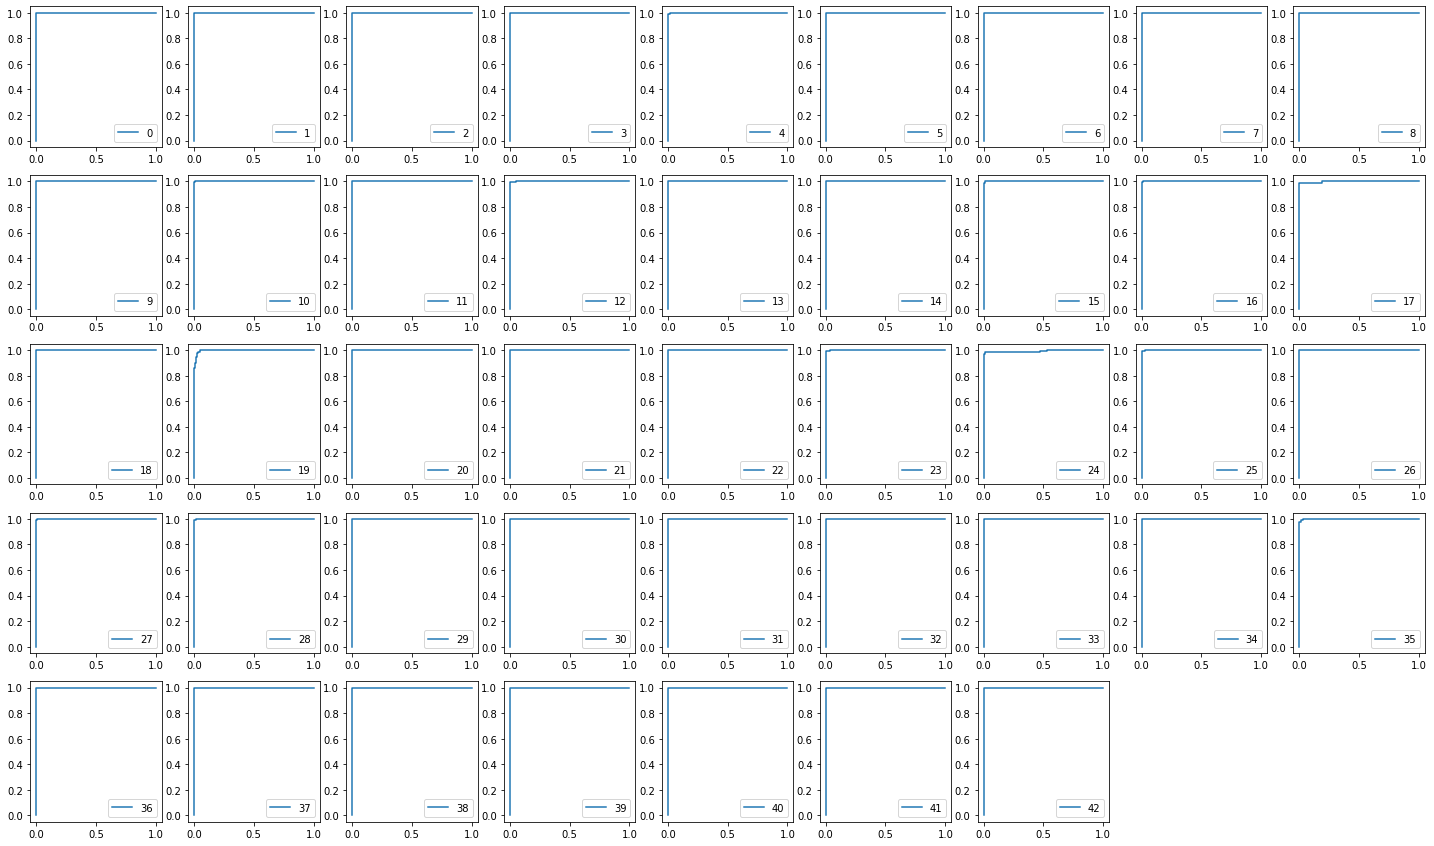

In [23]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score
def roc(df1, logit):

  data = df1.to_numpy()
  y = label_binarize(data[:, 0], classes=list(np.unique(data[:, 0])))
  n_classes = y.shape[1]
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], logit[:, i])

  return fpr, tpr

x,y = roc(test_df,tlogit)
plt.figure(figsize = (25,15))
for _ in range(len(x)):
  plt.subplot(5,int(n_classes/5+1),_+1)
  plt.plot(x[_],y[_])
  plt.legend([_])
plt.show()

# Precision & F1 per class

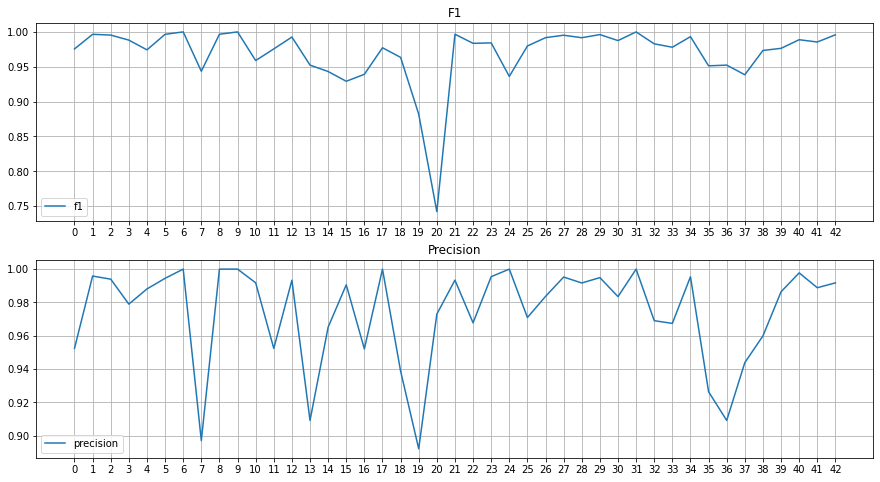

In [24]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score

def f1_per_class(df):

  data = df.to_numpy()
  return f1_score(data[:, 0], data[:, 1], average=None)

def precision_per_class(df):
  data = df.to_numpy()
  return precision_score(data[:,0],data[:,1],average=None)


plt.figure(figsize=(15,8))
f = f1_per_class(test_df)
plt.subplot(2,1,1)
plt.plot(f) 
plt.xticks(np.arange(0, n_classes, 1))
plt.grid()
plt.title('F1')
plt.legend(['f1'])

f = precision_per_class(test_df)
plt.subplot(2,1,2)
plt.plot(f) 
plt.title('Precision')
plt.legend(['precision'])
plt.xticks(np.arange(0, n_classes, 1))
plt.grid()
plt.show()

# **Uncertainty Analysis**
Epistemic uncertainty: Shows if the model is not trained on this data variety, or if the data or similar is never seen by the model. This uncertainty score is better than blantly guessing anything
- Low data training
- Improper training
- OoD detection

Aleatoric uncertainty: Shows the noise present in the data

# On full Test Data
Histogram of confidence estimates for correct, wrong classifications, and also for OoD samples

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype

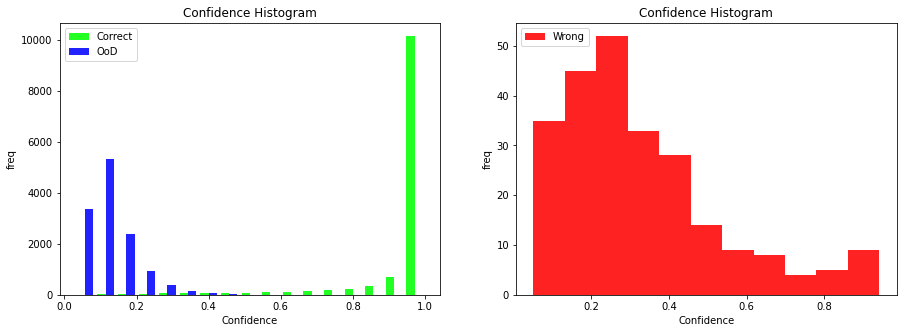

In [25]:
kernel_distace_normal,kernel_distace_wrong,kernel_distace_ood = [],[],[]
network.eval()

e=1
with torch.no_grad():
  for _,(data, target) in enumerate(test_loader):
    output = network(data.cuda())
    output = output.cpu()
    pred = output.argmax(1)
  ood = 0*data + e*torch.randn(data.shape)
  new_output = network(ood.cuda())
  new_output = new_output.cpu();
  newpred = new_output.argmax(1)

for i in range (len(target)):
  if target[i] == pred [i]:
    kernel_distace_normal.append(output[i].max(0)[0].item())
  else:
    kernel_distace_wrong.append(output[i].max(0)[0].item())
kernel_distace_ood = new_output.max(1)[0].tolist()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
n, bins, patches = plt.hist(x=[kernel_distace_normal,kernel_distace_ood], bins='auto', color=['#22FF22','#2222FF'])
plt.xlabel("Confidence"); plt.ylabel("freq"); plt.title("Confidence Histogram")
plt.legend(['Correct','OoD'],loc='upper left')
plt.subplot(1,2,2)
n, bins, patches = plt.hist(x=[kernel_distace_wrong], bins='auto', color=['#FF2222'])
plt.xlabel("Confidence"); plt.ylabel("freq"); plt.title("Confidence Histogram")
plt.legend(['Wrong'],loc='upper left')
plt.show()

# Per Class
Class Estimates for epistemic and aleatoric uncertainties

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


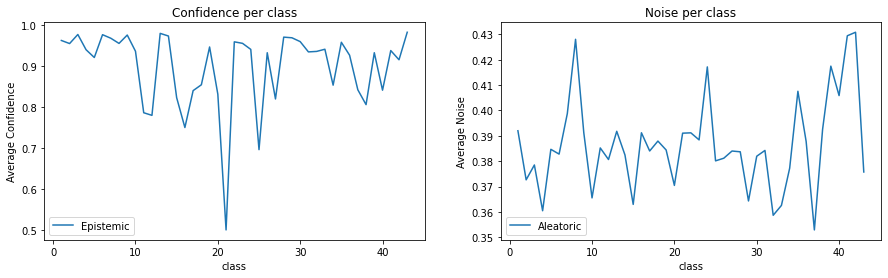

In [26]:
network.eval()
with torch.no_grad():
  for _,(data, target) in enumerate(test_loader):
    output = network(data.cuda())
    output = output.cpu(); 
    sigma = network.sigma.mean(1).cpu()
    target = target.long()

epistemic = np.empty((43, 0)).tolist()
aleatoric = np.empty((43, 0)).tolist()
for i in range (len(target)):
  epistemic[target[i].item()].append(output[i].max(0)[0].item())
  aleatoric[target[i].item()].append(sigma[i].item())
for i in range (43):
  epistemic[i] = np.array(epistemic[i]).mean()
  aleatoric[i] = np.array(aleatoric[i]).mean()


x = np.arange(1,43+1)
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(x, epistemic, label = "Epistemic")
plt.xlabel("class"); plt.ylabel("Average Confidence"); plt.title("Confidence per class");
plt.legend()

plt.subplot(1,2,2) 
plt.plot(x, aleatoric, label = "Aleatoric") 
plt.xlabel("class"); plt.ylabel("Average Noise"); plt.title("Noise per class");
plt.legend()
plt.show()

# Per Sample
Show uncertainties per Sample

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for 

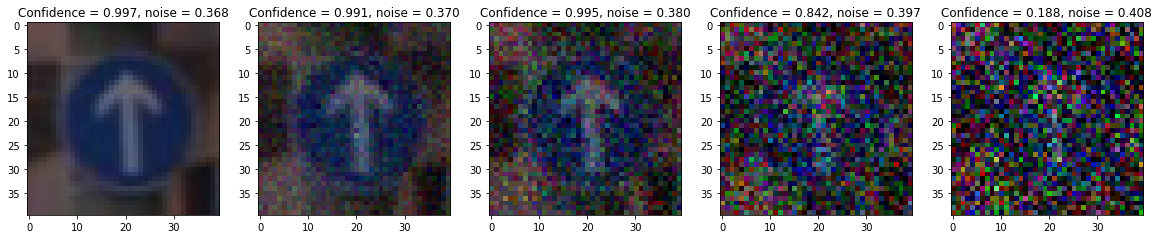

In [31]:
for i, (data,target) in enumerate(test_loader):
  break

er = [0,0.05,0.1,0.2,0.3]
ch = np.random.randint(len(data))
plt.figure(figsize=(4*len(er),4))
for i in range(len(er)):
  e = er[i]
  sample = (data[ch] + e*torch.randn(data[ch].shape))/(1+e)

  network.eval()
  output = network(sample.view(1,3,sz,sz).cuda()).cpu().view(-1)
  epistemic, aleatoric = output.max(0)[0].mean().item(), abs(network.sigma[0].item())
  
  plt.subplot(1,len(er),i+1)
  plt.imshow(sample.permute(1,2,0))
  plt.title("Confidence = {:.3f}, noise = {:.3f}".format(epistemic, aleatoric))


plt.show()

# Noise Detection

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Text(0, 0.5, 'frequency')

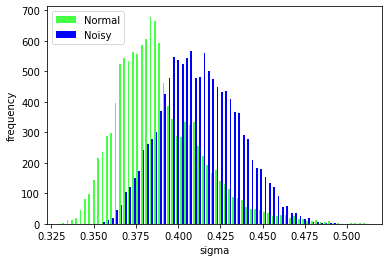

In [28]:
def indx(output,target):
  return -F.nll_loss(output,target.long(),reduce=False)
# indx(network.sigma.cpu(),target)
e = 0.2
torch.cuda.empty_cache()
network.eval()
with torch.no_grad():
  for i, (data,target) in enumerate(test_loader):
    nd = (data + e*torch.randn(data.shape))/(1+e)
    output = network(data.cuda())
   
    sign = network.sigma.cpu()
    newout = network(nd.cuda())
    newsign = network.sigma.cpu()
n, bins, patches = plt.hist(x=[sign.view(-1).numpy(),newsign.view(-1).numpy()], bins='auto', color=['#44FF44','blue'])
plt.legend(['Normal','Noisy'],loc='upper left')
plt.xlabel("sigma")
plt.ylabel("frequency")

# **GRAD CAM**

In [29]:
import cv2

def norm (a):
    a = (a-a.min())
    a/=(a.max())
    return a

def gradcam(model,img,st,tg):
  model.eval()
  img = img.cuda()
  out = model(img)
  pred = out.argmax(1).squeeze().item()

  model.grad = None
  out[:,tg].backward()
  gradients = model.grad
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
  activations = model.activations(img).detach()
  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]
  
  with torch.no_grad():
      heatmap = torch.mean(activations, dim=1).cpu().unsqueeze(1)
      heatmap = norm(torch.relu(heatmap));
      map = F.interpolate(heatmap,(sz,sz),mode='bilinear')
      
      map = map.squeeze().unsqueeze(2); img = img.squeeze().cpu().permute(1,2,0)*255; map = np.uint8(255 * map)
      map = cv2.applyColorMap(map, cv2.COLORMAP_JET)
      superimpose = (img + st*map)
      superimpose /= superimpose.max()
      plt.imshow(superimpose)
      plt.xlabel("Target")

def gradcam_(model,img,st):
  model.eval()
  img = img.cuda()
  out = model(img)
  pred = out.argmax(1).squeeze().item()

  model.grad = None
  model.sigma.backward()
  gradients = model.grad
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
  activations = model.activations(img).detach()
  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]
  
  with torch.no_grad():
      heatmap = torch.mean(activations, dim=1).cpu().unsqueeze(1)
      heatmap = norm(torch.relu(heatmap));
      map = F.interpolate(heatmap,(sz,sz),mode='bilinear')
      map = map.squeeze().unsqueeze(2); img = img.squeeze().cpu().permute(1,2,0)*255; map = np.uint8(255 * map)
      map = cv2.applyColorMap(map, cv2.COLORMAP_JET)
      superimpose = (img + st*map)
      superimpose /= superimpose.max()
      plt.imshow(superimpose)
      plt.xlabel("Sigma")

data = next(iter(test_loader));
data, target = data;

# For Target & Noise

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "Se

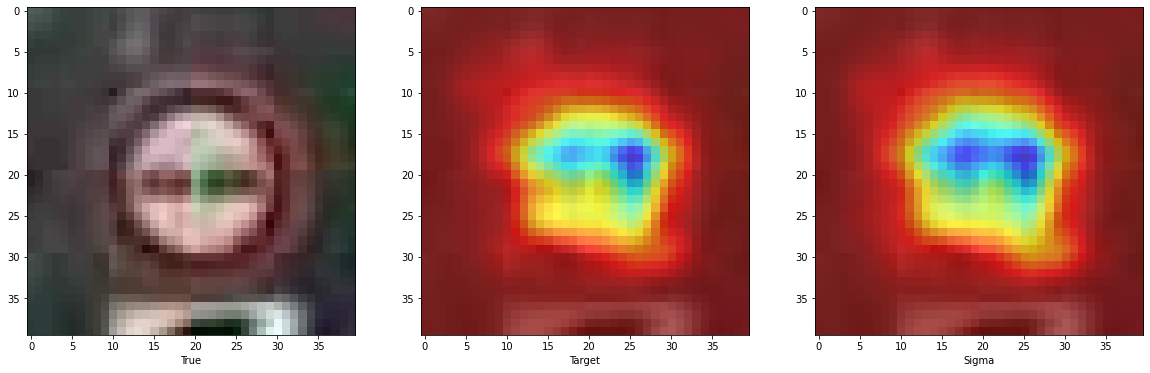

In [36]:
network.cam = True
ch = np.random.randint(len(test_loader.dataset))
img = data[ch]
tg = target[ch]

st = 0.7
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(norm(img).cpu().permute(1,2,0)); plt.xlabel("True")
plt.subplot(1,3,3)
gradcam_(network,img.unsqueeze(0),st)
plt.subplot(1,3,2)
gradcam(network,img.unsqueeze(0),st,tg)
network.cam = False

# Model Weights & Biases

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(14, 14))
Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(6, 6))
Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))


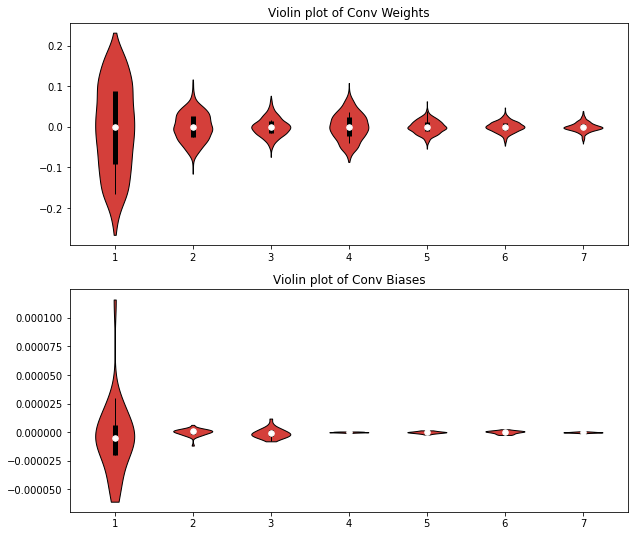

In [37]:
i=0
w = []
b = []
network.eval()
for m in network.modules():
    if isinstance(m, nn.Conv2d):
        w.append(m.weight.data.reshape(-1).cpu().detach().numpy()[0:864])
        b.append(m.bias.data.reshape(-1).cpu().detach().numpy()[0:32])

        i=i+1
        print(m)
    if i==7:
        break


def adjacent_values(vals, q1, q3):
      upper_adjacent_value = q3 + (q3 - q1) * 1.5
      upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

      lower_adjacent_value = q1 - (q3 - q1) * 1.5
      lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
      return lower_adjacent_value, upper_adjacent_value
def violinplot(pl,title):
  plt.title(title)
  parts = plt.violinplot(
          pl, showmeans=False, showmedians=False,
          showextrema=False)
  for pc in parts['bodies']:
      pc.set_facecolor('#D43F3A')
      pc.set_edgecolor('black')
      pc.set_alpha(1)
  quartile1, medians, quartile3 = np.percentile(pl, [25, 50, 75], axis=1)
  whiskers = np.array([
      adjacent_values(sorted_array, q1, q3)
      for sorted_array, q1, q3 in zip(pl, quartile1, quartile3)])
  whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
  inds = np.arange(1, len(medians) + 1)
  plt.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
  plt.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
  plt.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

plt.figure(figsize=(10,9))
plt.subplot(2,1,1)
violinplot(w,'Violin plot of Conv Weights')
plt.subplot(2,1,2)
violinplot(b,'Violin plot of Conv Biases')
plt.show()